In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

### Data

In [3]:
factors = pd.read_excel("../data/dfa_analysis_data.xlsx", sheet_name="factors", index_col=0)
portfolio_ret = pd.read_excel(
    "../data/dfa_analysis_data.xlsx", sheet_name="portfolios (total returns)", index_col=0)

In [4]:
factors.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1926-08-31,0.0264,-0.0117,0.0382,0.0025
1926-09-30,0.0036,-0.0140,0.0013,0.0023
1926-10-31,-0.0324,-0.0009,0.0070,0.0032
1926-11-30,0.0253,-0.0010,-0.0051,0.0031


In [5]:
portfolio_ret.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.0582,-0.0170,0.0049,-0.0146,0.0205,0.0121,0.0242,0.0049,-0.0260,-0.0033,...,0.0159,0.0153,0.0130,0.0027,0.0247,0.0345,0.0609,0.0203,0.0311,0.0056
1926-08-31,-0.0202,-0.0803,0.0138,0.0146,0.0840,0.0236,-0.0118,0.0401,0.0050,0.0617,...,0.0133,0.0387,0.0200,0.0217,0.0534,0.0101,0.0419,0.0201,0.0548,0.0776
1926-09-30,-0.0483,-0.0262,-0.0434,-0.0327,0.0086,-0.0265,-0.0126,0.0108,-0.0355,-0.0094,...,0.0109,-0.0053,-0.0176,0.0146,0.0087,-0.0129,0.0365,0.0009,-0.0075,-0.0243
1926-10-31,-0.0937,-0.0355,-0.0349,0.0344,-0.0255,-0.0281,-0.0327,-0.0507,-0.0802,-0.0132,...,-0.0334,-0.0266,-0.0211,-0.0311,-0.0535,-0.0274,-0.0301,-0.0224,-0.0467,-0.0581
1926-11-30,0.0559,0.0419,0.0246,-0.0445,0.0054,0.0310,-0.0237,0.0301,0.0515,0.0273,...,0.0344,0.0239,0.0373,0.0493,0.0182,0.0429,0.0253,0.0152,0.0366,0.0256


### Functions

In [10]:
def summary_stat(df, annual_factor, q=0.05):
    '''summary assets' mean return, voaltility(stdev) and sharpe ratio'''
    result = pd.DataFrame()
    result["mean"] = df.mean() * annual_factor
    result["volatility"] = df.std() * np.sqrt(annual_factor)
    result["Sharpe Ratio"] = result["mean"]/result["volatility"]

    result["VaR"] = df.quantile(q)
    return result

## 2. The Factors
### 2.1. The Factors. Calculate their univariate performance statistics:

In [41]:
del factors["RF"]

In [42]:
summary_stat(factors, 12, 0.05).T

,Mkt-RF,SMB,HML
mean,0.0808,0.0233,0.0423
volatility,0.1852,0.1099,0.1234
Sharpe Ratio,0.4361,0.2119,0.3430
VaR,-0.0796,-0.0420,-0.0419


In [43]:
print("Subsets: Beginning - 1980")
summary_stat(factors.loc[: "1980"], 12, 0.05).T

Subsets: Beginning - 1980


,Mkt-RF,SMB,HML
mean,0.0811,0.0340,0.0495
volatility,0.2051,0.1146,0.1338
Sharpe Ratio,0.3957,0.2966,0.3697
VaR,-0.0840,-0.0434,-0.0429


In [44]:
print("Subsets: 1981 - 2001")
summary_stat(factors["1981":"2001"],12).T

Subsets: 1981 - 2001


,Mkt-RF,SMB,HML
mean,0.0773,-0.0009,0.0637
volatility,0.1574,0.1184,0.1113
Sharpe Ratio,0.4908,-0.0074,0.5727
VaR,-0.0645,-0.0466,-0.0418


In [47]:
print("Subsets: 2002 - End")
summary_stat(factors.loc["2002": ], 12, 0.05).T

Subsets: 2002 - End


,Mkt-RF,SMB,HML
mean,0.0833,0.0196,0.0017
volatility,0.1540,0.0858,0.1045
Sharpe Ratio,0.5409,0.2288,0.0161
VaR,-0.0788,-0.0378,-0.0410


### 2.2 Based on the factor statistics above, answer the following.
#### (a) Does each factor have a premium (positive expected excess return) in each subsample?
* No. During the subsample period 1981-2001, the size factor(SMB) had a negative expected excess return of -0.0009. 
#### (b) Does the premium to the size factor get smaller after 1980?
* Yes. The premium to the size factor went to negative from 1981 to 2001, and it has gone back to positive since 2002, however still smaller than the premium before 1980. 
#### (c) Does the premium to the value factor get smaller during the 1990’s?
* Yes. Value factor went to negative during 1990's. 

In [48]:
summary_stat(factors["1990":"1999"],12).T

,Mkt-RF,SMB,HML
mean,0.1276,-0.0142,-0.0011
volatility,0.1383,0.1037,0.0917
Sharpe Ratio,0.9230,-0.1365,-0.0122
VaR,-0.0494,-0.0513,-0.0403


#### (d) How have the factors performed since the time of the case, (2002-present)?

* The market factor performs the best among all three factors. 
* The performance of size factor has become much better than that during 1980-2001, but still the best performance was before 1980. 
* The value factor has a poor performance during this period. The premium to the value factor is slightly above 0. 

### 2.3. Report the correlation matrix across the three factors. Does the construction method succeed in keeping correlations small? Does it achieve this in each subsample?

In [77]:
corr_matrix = factors.corr()
corr_matrix

,Mkt-RF,SMB,HML
Mkt-RF,1.0000,0.3163,0.2297
SMB,0.3163,1.0000,0.1147
HML,0.2297,0.1147,1.0000


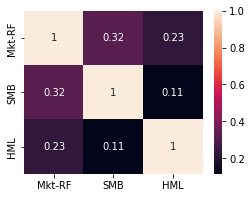

In [78]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True)

In [71]:
print("Subsample period: Beginning - 1980")
corr_matrix = factors[:"1980"].corr()
corr_matrix

Subsample period: Beginning - 1980


,Mkt-RF,SMB,HML
Mkt-RF,1.0000,0.3663,0.4378
SMB,0.3663,1.0000,0.3091
HML,0.4378,0.3091,1.0000


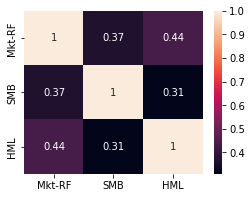

In [72]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True)

In [73]:
print("Subsample period: 1981 - 2001")
corr_matrix = factors["1981":"2001"].corr()
corr_matrix

Subsample period: 1981 - 2001


,Mkt-RF,SMB,HML
Mkt-RF,1.0000,0.1643,-0.5268
SMB,0.1643,1.0000,-0.4548
HML,-0.5268,-0.4548,1.0000


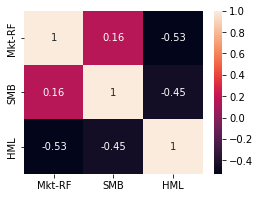

In [74]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True)

In [75]:
print("Subsample period: 2002 - End")
corr_matrix = factors["2002": ].corr()
corr_matrix

Subsample period: 2002 - End


,Mkt-RF,SMB,HML
Mkt-RF,1.0000,0.3162,0.1317
SMB,0.3162,1.0000,0.0929
HML,0.1317,0.0929,1.0000


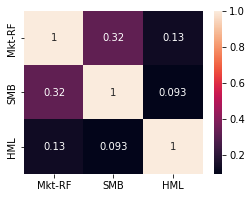

In [76]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True)

**Answers:** 
* Yes. The all-sample correlation is relatively small. For each sub-sample, it is small as well. 
* The correlations before 1980 are a bit higher than those of the other two subsamples and the full sample. 
* The corrrelations of value model to other two factors are negative during 1981-2001. 


### 2.4. Plot the cumulative returns of the three factors. Create plots for the 1981-2001 subsample as well as the 2002-Present subsample.

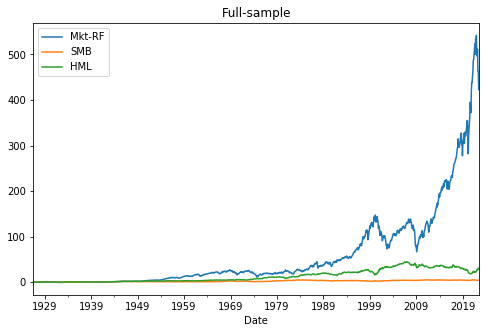

In [79]:
((factors + 1).cumprod()-1).plot(figsize=(8,5),title = "Full-sample")

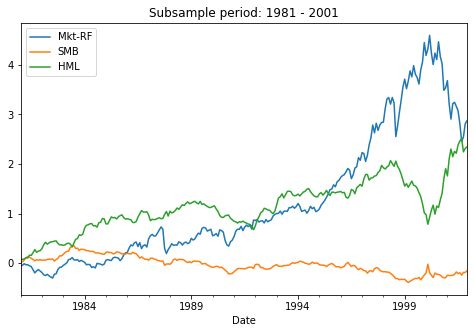

In [80]:
((factors["1981":"2001"] + 1).cumprod() - 1).plot(figsize=(8,5),title = "Subsample period: 1981 - 2001");

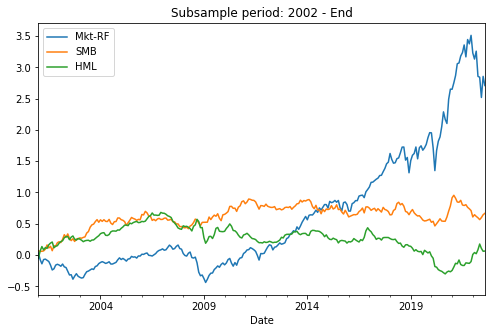

In [81]:
((factors["2001":] + 1).cumprod() - 1).plot(figsize=(8,5),title = "Subsample period: 2002 - End");

### 2.5. Does it appear that all three factors were valuable in 1981-2001? And post-2001? Would you advise DFA to continue emphasizing all three factors?
* The size factor does not appear to be very valuable in 1981-2001 as it has a negative premium. The value factor falls to negative post-2001, so it does not look attractive. However, even if SMB or HML have negative means or bad Sharpe ratios, they may still be valuable to DFA and DFAs investors due to their very small correlation to MKT. Thus, we shouldn’t rule them out just based on their stand-alone properties. We would want to examine their info ratios etc to better understand if they can be of use to an investor mostly invested in MKT.

## 3. CAPM
### Functions

In [155]:
def get_capm_matrics(targets, regressors, add_constant=True, annualize_factor=12):

    result = pd.DataFrame(index=targets.columns)
    resid_matrix = pd.DataFrame(columns=targets.columns)
    t_p_value = pd.DataFrame(index=targets.columns)

    if add_constant:
        X = sm.add_constant(regressors)
    else:
        X = regressors.copy()
    for column in targets.columns:
        y = targets[[column]]
        model = sm.OLS(y, X, missing='drop').fit()
        if add_constant:
            result.loc[column, "alpha"] = model.params['const'] * \
                annualize_factor
        result.loc[column, regressors.columns] = model.params[regressors.columns]
        if add_constant:
            result.loc[column, 'Info Ratio'] = np.sqrt(
                annualize_factor) * model.params['const'] / model.resid.std()

        if regressors.shape[1] == 1:
            result.loc[column, "Treynor Ratio"] = (
                y.mean().values[0]/model.params[regressors.columns].values[0]) * annualize_factor

        resid_matrix[column] = model.resid
        t_p_value.loc[column, "t-value"] = model.tvalues['const']
        t_p_value.loc[column, "p-value"] = model.pvalues['const']

    return result, resid_matrix, t_p_value


def cal_excess_tangency(df_ex, annual_factor):
    N = df_ex.shape[1]

    Sigma = df_ex.cov() * annual_factor
    Sigma_inv = np.linalg.inv(Sigma)
    mean_ex = df_ex.mean() * annual_factor

    w_t = 1/(np.ones(N) @ Sigma_inv @ mean_ex) * Sigma_inv @ mean_ex
    return pd.Series(w_t, index=df_ex.columns)


### Data

In [98]:
portfolio_ret.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.0582,-0.0170,0.0049,-0.0146,0.0205,0.0121,0.0242,0.0049,-0.0260,-0.0033,...,0.0159,0.0153,0.0130,0.0027,0.0247,0.0345,0.0609,0.0203,0.0311,0.0056
1926-08-31,-0.0202,-0.0803,0.0138,0.0146,0.0840,0.0236,-0.0118,0.0401,0.0050,0.0617,...,0.0133,0.0387,0.0200,0.0217,0.0534,0.0101,0.0419,0.0201,0.0548,0.0776
1926-09-30,-0.0483,-0.0262,-0.0434,-0.0327,0.0086,-0.0265,-0.0126,0.0108,-0.0355,-0.0094,...,0.0109,-0.0053,-0.0176,0.0146,0.0087,-0.0129,0.0365,0.0009,-0.0075,-0.0243
1926-10-31,-0.0937,-0.0355,-0.0349,0.0344,-0.0255,-0.0281,-0.0327,-0.0507,-0.0802,-0.0132,...,-0.0334,-0.0266,-0.0211,-0.0311,-0.0535,-0.0274,-0.0301,-0.0224,-0.0467,-0.0581
1926-11-30,0.0559,0.0419,0.0246,-0.0445,0.0054,0.0310,-0.0237,0.0301,0.0515,0.0273,...,0.0344,0.0239,0.0373,0.0493,0.0182,0.0429,0.0253,0.0152,0.0366,0.0256


### 3.1. Summary Statistics. For each portfolio,

Use the Risk-Free rate column in the factors tab to convert these total returns to excess returns.

In [99]:
factors = pd.read_excel("../data/dfa_analysis_data.xlsx",
                        sheet_name="factors", index_col=0)
portfolio_ex = portfolio_ret.subtract(factors["RF"], axis="rows")

# subsample
factors = factors["1981": ]
portfolio_ex = portfolio_ex["1981": ]

In [100]:
portfolio_ex.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-31,-0.0549,-0.0149,0.0099,0.0059,0.0211,-0.0597,-0.0107,-0.0127,0.0076,0.0206,...,-0.0770,-0.0449,-0.0129,-0.0055,0.0039,-0.0717,-0.0836,-0.0743,-0.0100,0.0095
1981-02-28,-0.0447,-0.0105,0.0014,0.0092,0.0144,-0.0145,0.0051,0.0174,0.0244,0.0279,...,0.0026,0.0147,0.0347,0.0027,0.0272,0.0219,0.0094,-0.0164,0.0204,-0.0169
1981-03-31,0.0607,0.0824,0.0736,0.0777,0.0610,0.0681,0.0715,0.0663,0.0663,0.0632,...,0.0804,0.0557,0.0732,0.0619,0.0649,0.0174,0.0199,-0.0089,0.0222,0.0696
1981-04-30,0.0181,0.0359,0.0246,0.0365,0.0441,0.0060,0.0247,0.0266,0.0268,0.0294,...,-0.0108,-0.0191,-0.0060,-0.0078,0.0063,-0.0383,-0.0535,-0.0380,0.0104,-0.0404
1981-05-31,0.0382,0.0378,0.0324,0.0134,0.0168,0.0505,0.0103,0.0169,-0.0086,0.0136,...,0.0240,0.0102,0.0076,-0.0008,0.0220,0.0043,-0.0328,-0.0314,0.0267,-0.0060


Calculate the (annualized) univariate statistics from 1.1.

In [101]:
summary = summary_stat(portfolio_ex, 12)
summary

,mean,volatility,Sharpe Ratio,VaR
SMALL LoBM,0.0105,0.2724,0.0384,-0.1165
ME1 BM2,0.0957,0.2359,0.4058,-0.0976
ME1 BM3,0.0929,0.1972,0.4711,-0.0864
ME1 BM4,0.1200,0.1914,0.6270,-0.0752
SMALL HiBM,0.1321,0.2077,0.6361,-0.0883
ME2 BM1,0.0603,0.2457,0.2453,-0.1046
ME2 BM2,0.1006,0.2032,0.4953,-0.0840
ME2 BM3,0.1066,0.1831,0.5824,-0.0787
ME2 BM4,0.1077,0.1792,0.6012,-0.0764
ME2 BM5,0.1181,0.2120,0.5571,-0.0942


Can the difference in mean excess returns of the portfolios be explained by differences in
their volatilities? Or by their VaR(.05) statistics?

In [102]:
X = summary["volatility"]
y = summary["mean"]
static_model = sm.OLS(y, X).fit()
static_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   mean   R-squared (uncentered):                   0.893
Model:                            OLS   Adj. R-squared (uncentered):              0.888
Method:                 Least Squares   F-statistic:                              199.5
Date:                Fri, 21 Oct 2022   Prob (F-statistic):                    4.00e-13
Time:                        15:25:32   Log-Likelihood:                          50.676
No. Observations:                  25   AIC:                                     -99.35
Df Residuals:                      24   BIC:                                     -98.13
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
volatility     0.4680      0.033     14.123      0.000       0.400       0.536
==============================================================================
Omnibus:                       29.844   Durbin-Watson:                   1.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.203
Skew:                          -2.363   Prob(JB):                     8.46e-14
Kurtosis:                       8.954   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

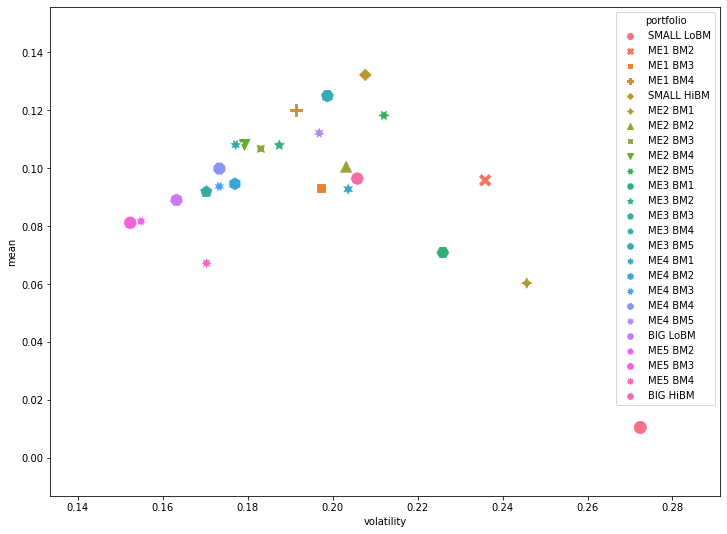

In [103]:
summary["portfolio"] = summary.index
fig, ax = plt.subplots(figsize=(12, 9))
sns.scatterplot(
    data=summary, x="volatility", y="mean", hue="portfolio", legend="auto", style="portfolio", 
    s = 200
)
# size="volatility", sizes=(20, 200)


In [104]:
X = summary["VaR"]
y = summary["mean"]
static_model = sm.OLS(y, X).fit()
static_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   mean   R-squared (uncentered):                   0.886
Model:                            OLS   Adj. R-squared (uncentered):              0.881
Method:                 Least Squares   F-statistic:                              186.8
Date:                Fri, 21 Oct 2022   Prob (F-statistic):                    8.07e-13
Time:                        15:25:34   Log-Likelihood:                          49.948
No. Observations:                  25   AIC:                                     -97.90
Df Residuals:                      24   BIC:                                     -96.68
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
VaR           -1.0875      0.080    -13.669      0.000      -1.252      -0.923
==============================================================================
Omnibus:                       26.064   Durbin-Watson:                   1.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.727
Skew:                          -2.125   Prob(JB):                     1.94e-10
Kurtosis:                       7.988   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

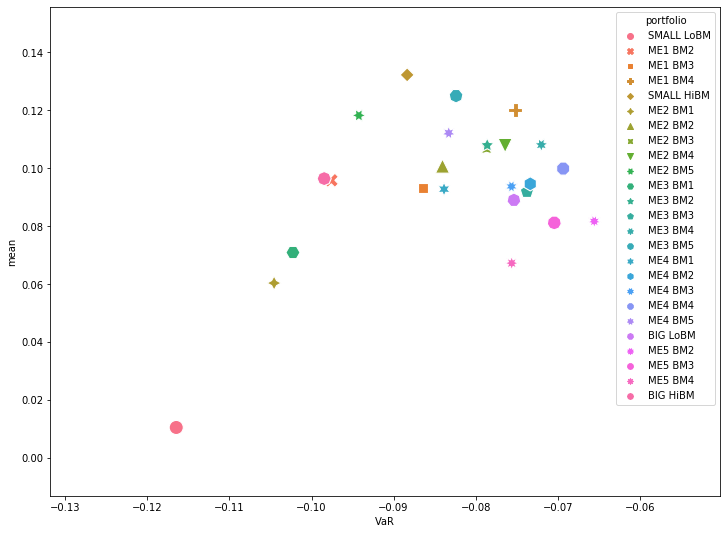

In [105]:
summary["portfolio"] = summary.index
fig, ax = plt.subplots(figsize=(12, 9))
sns.scatterplot(
    data=summary, x="VaR", y="mean", hue="portfolio", legend="auto", style="portfolio",
    s=200
)

### 3.2. CAPM 
#### (a) For each of the n = 25 test portfolios, run the CAPM time-series regression:
#### (b) Report the estimated βi,m, Treynor Ratio, αi, and Information Ratio for each of the n regressions.

In [156]:
capm_res, resid_matrix, t_p_values = get_capm_matrics(portfolio_ex, factors[['Mkt-RF']], add_constant=True, annualize_factor=12)
capm_res

,alpha,Mkt-RF,Info Ratio,Treynor Ratio
SMALL LoBM,-0.0987,1.3600,-0.5750,0.0077
ME1 BM2,0.0018,1.1702,0.0122,0.0818
ME1 BM3,0.0097,1.0365,0.0857,0.0896
ME1 BM4,0.0425,0.9652,0.3585,0.1243
SMALL HiBM,0.0526,0.9907,0.3778,0.1333
ME2 BM1,-0.0475,1.3433,-0.3677,0.0449
ME2 BM2,0.0101,1.1286,0.0984,0.0892
ME2 BM3,0.0248,1.0193,0.2712,0.1046
ME2 BM4,0.0303,0.9654,0.3094,0.1116
ME2 BM5,0.0292,1.1086,0.2363,0.1066


#### (c) If (CAPM) were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?

* Treynor Ratio

$$\text{Treynor Ratio} \equiv \frac{\tilde\mu}{\beta}$$

* Information ratio

$$\text{Information Ratio} \equiv \frac{\alpha}{\sigma_\epsilon}$$

**Answers**

* If CAPM were true, the alphas and the Information Ratios would all be zero. The Treynor Ratios would all equal to the mean excess market return.

### 3.3. Cross-sectional Estimation
* (a) Report the R-squared of this regression.
* (b) Report the intercept, η.
* (c) Report the regression coefficient, λm.

What would these three statistics be if (CAPM) were true?

In [107]:
# we use sample means as estimates of E[r ̃i].
y = portfolio_ex.mean()
beta = capm_res[["Mkt-RF"]]
X = sm.add_constant(beta)

static_model = sm.OLS(y, X, missing='drop').fit()
static_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     8.008
Date:                Fri, 21 Oct 2022   Prob (F-statistic):            0.00950
Time:                        15:26:47   Log-Likelihood:                 123.51
No. Observations:                  25   AIC:                            -243.0
Df Residuals:                      23   BIC:                            -240.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0165      0.003      5.362      0.000       0.010       0.023
Mkt-RF        -0.0082      0.003     -2.830      0.009      -0.014      -0.002
==============================================================================
Omnibus:                        4.531   Durbin-Watson:                   1.311
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                2.975
Skew:                          -0.820   Prob(JB):                        0.226
Kurtosis:                       3.408   Cond. No.                         17.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
# Annualize intercept
static_model.params[0] * 12

0.19798077049490967

In [110]:
# Annualize lambda
static_model.params[1] * 12

-0.09815760379979327

**Answers:**

* For the cross-sectional regression, $R^2$ equal to 0.258, and the intercept is 0.198 with t-value 5.36, the regression coefficient is -0.098. 
* If CAPM would work,  $R^2$ should be high enough (to 100%) because beta should explain excess return, and should be the one and only reason for the difference of excess returns. Also, intercept should be zero. 
* The regression coefficient should equal to the mean excess market return. If you take higher risk, you should gain higer excess returns; if you take one unit of market risk, you should gain tthe mean excess market return. 

### 3.4. Broadly speaking, do these results support DFA’s belief in size and value portfolios containing premia unrelated to the CAPM?

* Our results support DFA's view that there are risks beyound market beta, but there's no enough evidence to show that size and value factors matter.  

## 4. Extensions
### 4.1. Use all 3 factors

In [157]:
capm_res_3factor, resid_matrix_3factor, t_p_values_3factor = get_capm_matrics(
    portfolio_ex, factors[['Mkt-RF', "SMB", "HML"]], add_constant=True, annualize_factor=12)
capm_res_3factor


,alpha,Mkt-RF,SMB,HML,Info Ratio
SMALL LoBM,-8.3200e-02,1.1162,1.3722,-0.2629,-0.9288
ME1 BM2,5.9122e-03,0.9722,1.3145,-0.0126,0.0847
ME1 BM3,8.6004e-05,0.9216,1.0463,0.2774,0.0019
ME1 BM4,2.3969e-02,0.8783,1.0580,0.4768,0.5033
SMALL HiBM,2.4209e-02,0.9359,1.0610,0.6956,0.3231
ME2 BM1,-2.9881e-02,1.1424,1.0150,-0.3323,-0.4994
ME2 BM2,7.0806e-03,1.0120,0.9012,0.1201,0.1421
ME2 BM3,8.8349e-03,0.9730,0.7078,0.3982,0.1705
ME2 BM4,6.2321e-03,0.9409,0.7422,0.5797,0.1390
ME2 BM5,-5.2842e-03,1.0933,0.9219,0.8224,-0.1127


### 4.2. Re-do the analysis of 3.3 and 3.3, but instead of using the market return as the factor, use a new factor: the in-sample tangency portfolio of the n = 25 portfolios.
* Calculate r ̃tan by solving the MV optimization of the n excess returns.

In [119]:
tangency_weight = cal_excess_tangency(portfolio_ex, annual_factor=12)

In [158]:
tangency_ret = (tangency_weight * portfolio_ex).sum(axis=1)
X = pd.DataFrame(tangency_ret, columns=["tangency return"])

tan_report, resid_matrix_tan, _ = get_capm_matrics(portfolio_ex, X, add_constant=True, annualize_factor=12)
tan_report

,alpha,tangency return,Info Ratio,Treynor Ratio
SMALL LoBM,-5.1001e-16,0.0259,-1.8726e-15,0.4046
ME1 BM2,-5.2042e-17,0.2366,-2.2585e-16,0.4046
ME1 BM3,-2.7062e-16,0.2296,-1.4168e-15,0.4046
ME1 BM4,-4.7878e-16,0.2965,-2.6513e-15,0.4046
SMALL HiBM,-3.5388e-16,0.3264,-1.8090e-15,0.4046
ME2 BM1,2.8103e-16,0.1490,1.1535e-15,0.4046
ME2 BM2,-7.4290e-16,0.2487,-3.7886e-15,0.4046
ME2 BM3,-3.9812e-16,0.2635,-2.2854e-15,0.4046
ME2 BM4,-2.2248e-16,0.2663,-1.3090e-15,0.4046
ME2 BM5,-8.3137e-16,0.2919,-4.1021e-15,0.4046


In [132]:
X = sm.add_constant(tan_report['tangency return'])
y = portfolio_ex.mean(axis=0)

res = sm.OLS(y, X, missing='drop').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.658e+29
Date:                Sat, 22 Oct 2022   Prob (F-statistic):          7.11e-322
Time:                        11:07:52   Log-Likelihood:                 921.59
No. Observations:                  25   AIC:                            -1839.
Df Residuals:                      23   BIC:                            -1837.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.366e-17   1.99e-17     -0.686      0.499   -5.48e-17    2.75e-17
tangency return     0.0337   8.28e-17   4.07e+14      0.000       0.034       0.034
==============================================================================
Omnibus:                        0.021   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.989   Jarque-Bera (JB):                0.203
Skew:                          -0.048   Prob(JB):                        0.903
Kurtosis:                       2.569   Cond. No.                         17.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The cross-sectional regression coefficient for tangency beta is exactly the same as the expected premium to tangency portfolio.


#### 4.3. In problem 2.3, we measured how well the CAPM performs by running the analogous regression. In fact, we could have assessed it directly from the time-series regressions.
* (a) Report the mean-absolute-error of the CAPM:

In [136]:
# already annualized
np.abs(capm_res["alpha"]).mean()

0.024271238013034557

* (b) So under the null hypothesis of the CAPM holding, H should be small, and the distribution allows us to calculate the probability of seeing such a large H, conditional on the CAPM being true. 
* **Answers:** The joint test rejects that the CAPM holds, even at a critical value of $0.01\%$.

In [148]:
T = portfolio_ex.dropna().shape[0]
# annualize? 
SR = factors['Mkt-RF'].mean() / factors['Mkt-RF'].std()
Sigma = resid_matrix.cov()
Sigma_inv = pd.DataFrame(np.linalg.inv(
    Sigma), index=Sigma.index, columns=Sigma.columns)
alpha = capm_res['alpha']
H = T * (1 + SR**2)**(-1) * alpha @ Sigma_inv @ alpha
print('H = {:.2f}'.format(H))
pvalue = 1 - stats.chi2.cdf(H, df=25)
print('p-value = {:.4f}'.format(pvalue))

H = 20068.02
p-value = 0.0000


* (c) Which is a stricter test: checking whether any of the n values of αi have a statistically significant t-test or checking whether H calculated above is significant?

In [159]:
display(t_p_values.sort_values(by='p-value', ascending=False))

,t-value,p-value
ME1 BM2,0.0775,0.9382
ME4 BM1,-0.2250,0.8221
ME5 BM4,-0.3397,0.7342
ME1 BM3,0.5468,0.5847
ME2 BM2,0.6276,0.5306
BIG HiBM,0.7185,0.4728
ME5 BM2,0.8102,0.4182
ME4 BM2,0.9342,0.3506
ME5 BM3,1.0249,0.3059
BIG LoBM,1.1152,0.2653


* **Answers:** 7 constants are significant, and other 18 are not significant different to zero. 

* (d) Conceptually, how does the test-statistic H relate to checking whether r ̃ spans the tan- gency portfolio?